***Dataset Name: Ames Housing (House Prices)***

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

In [5]:
data = fetch_openml(name="house_prices", as_frame=True)
df = data.frame

df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print("Dataset shape:", df.shape)

Dataset shape: (1460, 81)


In [7]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

In [8]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [12]:
num_imputer = SimpleImputer(strategy="median")
X[num_features] = num_imputer.fit_transform(X[num_features])

In [10]:
cat_imputer = SimpleImputer(strategy="most_frequent")
X[cat_features] = cat_imputer.fit_transform(X[cat_features])

In [11]:
X = pd.get_dummies(X, drop_first=True)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [16]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.0)
X_train_vt = vt.fit_transform(X_train)
X_test_vt = vt.transform(X_test)

In [17]:
selector = SelectKBest(score_func=f_regression, k=30)

X_train_sel = selector.fit_transform(X_train_vt, y_train)
X_test_sel = selector.transform(X_test_vt)

In [19]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=30)

X_train_sel = selector.fit_transform(X_train_vt, y_train)
X_test_sel = selector.transform(X_test_vt)

**Linear Regression Model**

In [22]:
lr = LinearRegression()
lr.fit(X_train_sel, y_train)

y_pred = lr.predict(X_test_sel)

In [23]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression")
print("R² Score:", r2)
print("RMSE:", rmse)

Linear Regression
R² Score: 0.8374448461270376
RMSE: 35310.77819682142


**K-Fold Cross-Validation (5-Fold)**

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    LinearRegression(),
    X_train_sel,
    y_train,
    cv=kf,
    scoring="r2"
)

print("Mean CV R²:", cv_scores.mean())

Mean CV R²: 0.7760609011613268


# **Model Enhancement**
Ridge Regression

In [25]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_sel, y_train)

print("Ridge R²:", r2_score(y_test, ridge.predict(X_test_sel)))


Ridge R²: 0.8369042512160447


Lasso Regression

In [26]:
lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(X_train_sel, y_train)

print("Lasso R²:", r2_score(y_test, lasso.predict(X_test_sel)))

Lasso R²: 0.8374448683406817


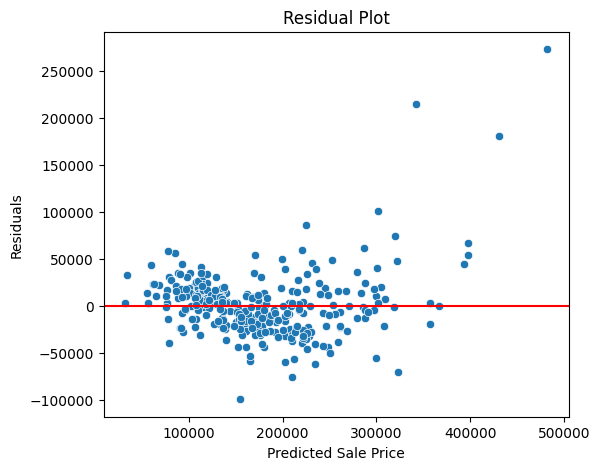

In [27]:
residuals = y_test - y_pred

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

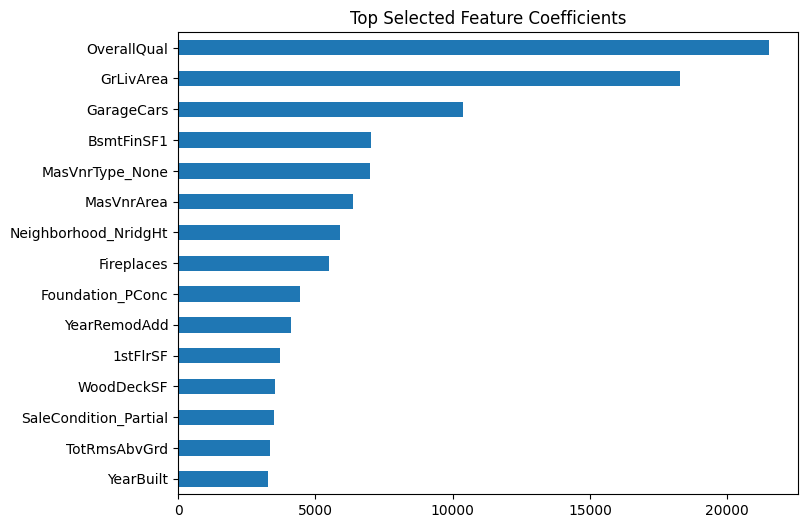

In [28]:
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[vt.get_support()][selected_feature_indices]

importance = pd.Series(lr.coef_, index=selected_features).sort_values()

importance.tail(15).plot(kind="barh", figsize=(8,6))
plt.title("Top Selected Feature Coefficients")
plt.show()

Highlights which housing attributes most influence sale prices.

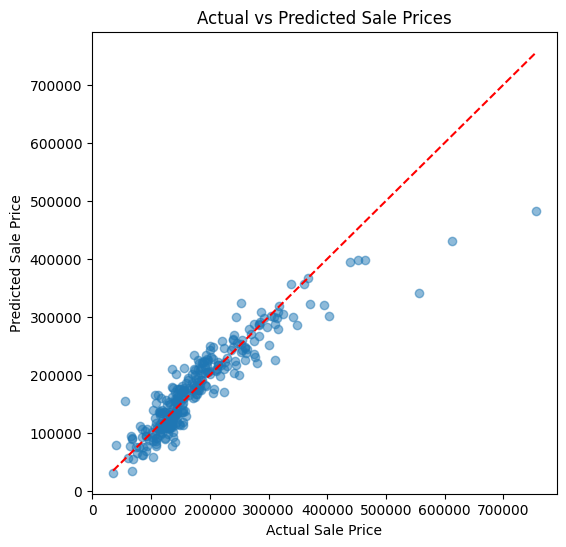

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.show()

Most points lie near the diagonal line, indicating good predictive performance.

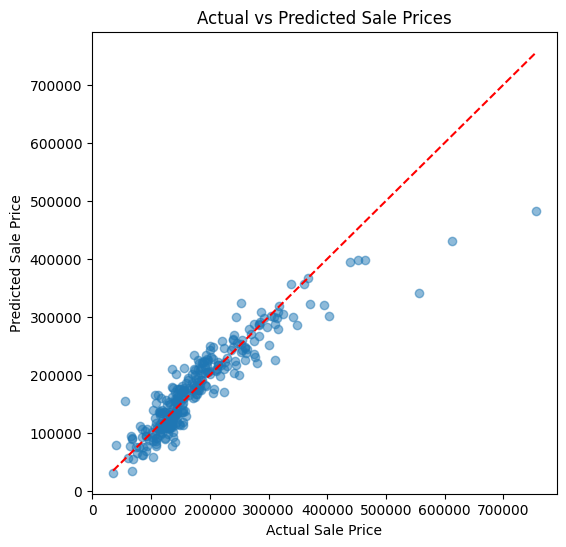

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--"
)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.show()


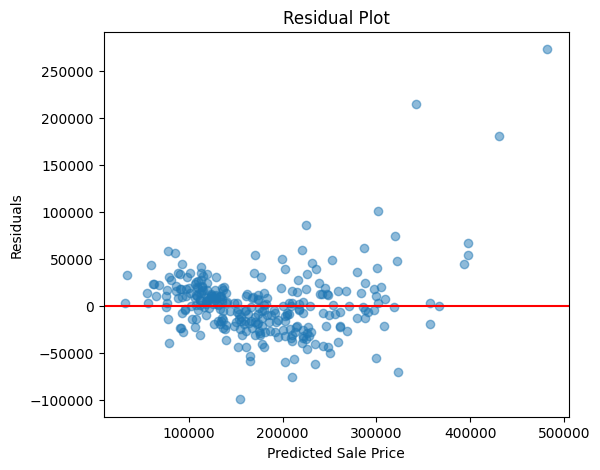

In [31]:
residuals = y_test - y_pred

plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

*Residuals randomly scattered around zero suggest the linear model is appropriate.*

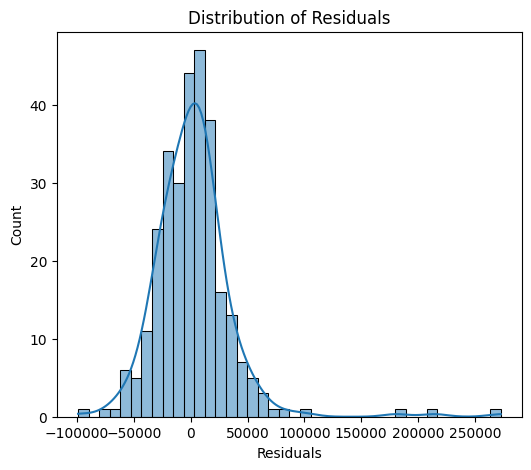

In [32]:
plt.figure(figsize=(6,5))
sns.histplot(residuals, bins=40, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

*A symmetric distribution centered near zero indicates unbiased predictions.*

Visualizations help assess both interpretability and performance of any given regression model. An actual versus predicted plot indicated that our predictions from the regression model match closely with actual house price data. Residual plots and residual distribution assessments revealed bias, variance, and pattern in the model’s prediction error. Feature coefficient analysis allowed us to determine which features were having a large impact on house prices. These visualizations enhance transparency, provide support for model validation, and yield an insightful way to interpret results of the regression analysis.